# 第7章 支持向量机

配置环境：python 3.6

代码全部测试通过。

代码参考 : https://github.com/wzyonggege/statistical-learning-method/blob/master/SVM/support-vector-machine.ipynb

此文档方便阅读讲解，若需要复制粘贴可以在当前目录中查看`SVM.py`

**这一章到后面的 SMO 算法还是很难的，我手推了一下才艰难弄懂个大概**


In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# 产生数据
def create_data():
    iris = load_iris()
    df = pd.DataFrame(iris.data, columns=iris.feature_names)
    df['label'] = iris.target
    df.columns = ['sepal length', 'sepal width',
                  'petal length', 'petal width', 'label']
    data = np.array(df.iloc[:100, [0, 1, -1]])
    for i in range(len(data)):
        if data[i, -1] == 0:
            data[i, -1] = -1
    return data[:, :2], data[:, -1]

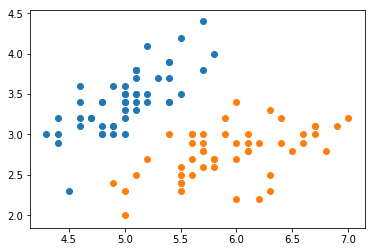

In [3]:
X, y = create_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
plt.scatter(X[:50, 0], X[:50, 1], label='0')
plt.scatter(X[50:, 0], X[50:, 1], label='1')

In [4]:
class SVM():
    # 加载数据
    def load_data(self, X, y):
        self.X = X
        self.y = y

    def kernel(self, x1, x2):
        """
        :param x1 [1, 2, 4]
        :param x2 [4, 5, 6]
        计算核函数
        如果是最普通的线性核函数
        x1 与 x2 内积，最直观的解释就是，对应元素相乘求和。1*4 + 2*5 + 4*6
        """
        if self.kernel_type == 'linear':
            return sum([x1[k]*x2[k] for k in range(self.features_len)])
        # 其他类型的核函数
        # 书上公式 7.88
        elif self.kernel_type == 'poly':
            return (sum([x1[k]*x2[k] for k in range(self.features_len)]) + 1)**2

        return 0

    def g(self, idx):
        """
        书上公式 7.104
        """
        r = self.b
        for j in range(self.samples_len):
            r += self.alpha[j]*self.y[j]*self.kernel(self.X[idx], self.X[j])
        return r


    def compute_E(self, idx):
        """
        书上公式 7.105
        """
        return self.g(idx) - self.y[idx]

    def KKT(self, idx):
        """
        判断是否满足 KKT 条件
        """
        t = self.y[idx]*self.g(idx)
        # 公式 7.111
        if self.alpha[idx] == 0:
            return t >= 1
        # 公式 7.112
        elif 0 < self.alpha[idx] < self.C:
            return t == 1
        # 公式 7.113
        else:
            return t <= 1
    
    # 初始化参数
    def init_args(self, kernel_type='linear', c=0.0001):
        self.samples_len, self.features_len = self.X.shape
        self.b = 0.0
        self.kernel_type = kernel_type 
        self.alpha = np.zeros(self.samples_len)
        self.E = [self.compute_E(i) for i in range(self.samples_len)]
        # 松弛变量，通过调节松弛变量可以提高准确率
        self.C = c

    def init_alpha(self):
        # 寻找所有属于 (0, C) 变量的点
        l1 = [i for i in range(self.samples_len) if 0 < self.alpha[i] < self.C]
        # 否则遍历所有点
        l2 = [i for i in range(self.samples_len) if i not in l1]
        # 合并两个数组
        l1.extend(l2)

        for i in l1:
            # 书上说，要选择最严重的。这里图简单就没有用最严重违反 KKT 条件的
            # 选择第一个违反 KKT 条件
            if self.KKT(i):
                continue
            # 书 129 页，第二个变量的选择
            E = self.E[i]
            if E > 0:
                j = min(range(self.samples_len), key=lambda x: self.E[x])
            else:
                j = max(range(self.samples_len), key=lambda x: self.E[x])

            return i, j
        
    def compare(self, alpha, L, H):
        """
        将新的 alpha 限制在 [L, H] 中
        如果比 H 大取 H
        如果比 L 小取 L
        如果在 [L, H] 之间, 取本身
        书上公式 7.108
        """
        if alpha < L:
            return L
        elif alpha > H:
            return H
        else:
            return alpha

    def train(self, max_iters=100):
        for t in range(max_iters):
            # 选择两个变量,书上 128 变量的选择方式 
            i1, i2 = self.init_alpha()
            # 计算边界 由 old 值计算
            if self.y[i1] == self.y[i2]:
                # 书上公式 126 页最下面两个公式的第二个
                L = max(0, self.alpha[i1]+self.alpha[i2] - self.C)
                H = min(self.C, self.alpha[i1]+self.alpha[i2])
            else:
                # 书上公式 126 页最下面两个公式的第一个
                L = max(0, self.alpha[i2]-self.alpha[i1])
                H = min(self.C, self.C + self.alpha[i2]-self.alpha[i1])

            E1 = self.E[i1]
            E2 = self.E[i2]
            # 书上公式 7.107
            eta = self.kernel(self.X[i1], self.X[i1]) + self.kernel(
                self.X[i2], self.X[i2]) - 2*self.kernel(self.X[i1], self.X[i2])

            if eta <= 0:
                continue

            # 计算新的未修剪的 alpha2
            alpha2_new_unc = self.alpha[i2] + self.y[i2] * (E1 - E2) / eta
            # 修剪的 alpha2 书上公式 7.108
            alpha2_new = self.compare(alpha2_new_unc, L, H)
            # 计算 alpha1  书上公式 7.109
            alpha1_new = self.alpha[i1] + self.y[i1] * \
                self.y[i2] * (self.alpha[i2] - alpha2_new)
            # 书上公式 7.114 7.115 7.116
            b1_new = -E1 - self.y[i1] * self.kernel(self.X[i1], self.X[i1]) * (
                alpha1_new-self.alpha[i1]) - self.y[i2] * self.kernel(self.X[i2], self.X[i1]) * (alpha2_new-self.alpha[i2]) + self.b
            b2_new = -E2 - self.y[i1] * self.kernel(self.X[i1], self.X[i2]) * (
                alpha1_new-self.alpha[i1]) - self.y[i2] * self.kernel(self.X[i2], self.X[i2]) * (alpha2_new-self.alpha[i2]) + self.b

            if 0 < alpha1_new < self.C:
                b_new = b1_new
            elif 0 < alpha2_new < self.C:
                b_new = b2_new
            else:
                # 选择中点
                b_new = (b1_new + b2_new) / 2

            # 更新参数
            self.alpha[i1] = alpha1_new
            self.alpha[i2] = alpha2_new
            self.b = b_new
            # 书上公式 7.117
            self.E[i1] = self.compute_E(i1)
            self.E[i2] = self.compute_E(i2)
        
        print('train done!')

    def predict(self, x):
        """
        预测类别
        g(x) 书上公式 7.104
        如果大于 0 预测 1
        小于 0 预测 -1
        """
        r = self.b
        for i in range(self.samples_len):
            r += self.alpha[i] * self.y[i] * self.kernel(x, self.X[i])

        return 1 if r > 0 else -1

    def score(self, X_test, y_test):
        """
        通过计算 预测值正确数目/总样本数目 算出得分
        """
        r = 0
        for i in range(len(X_test)):
            x = X_test[i]
            result = self.predict(x)
            if result == y_test[i]:
                r += 1
        return r / len(X_test)

    def weight(self):
        """
        计算权值
        """
        yx = self.y.reshape(-1, 1)*self.X
        self.w = np.dot(yx.T, self.alpha)
        return self.w

In [9]:
svm = SVM()
svm.load_data(X_train, y_train)
svm.init_args()
svm.train(200)

score = svm.score(X_test, y_test)

print('score', score)

train done!
score 1.0


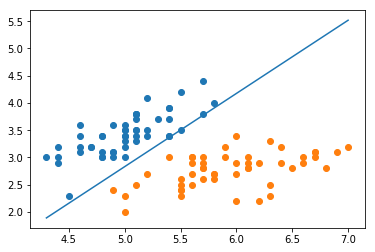

In [10]:
# 画点
plt.scatter(X[:50, 0], X[:50, 1], label='0')
plt.scatter(X[50:, 0], X[50:, 1], label='1')
# 计算权值
a1, a2 = svm.weight()
b = svm.b
x_min = min(svm.X, key=lambda x: x[0])[0]
x_max = max(svm.X, key=lambda x: x[0])[0]

y1, y2 = (-b - a1 * x_min)/a2, (-b - a1 * x_max)/a2
plt.plot([x_min, x_max], [y1, y2])
plt.show()